### Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import SimpleExpSmoothing


from scipy.optimize import minimize
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_predict

from scipy.stats import boxcox

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
series = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/mean-monthly-air-temperature-deg.csv")["Deg"]

### Определение основных функций

**Тест Дики-Фуллера на стационарность**

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

**Функция вывода коррелограмм**

In [5]:
def tsplot(y, lags=None, figsize=(12, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

### ARIMA

**ARIMA** расшифровывается как авторегрессионная интегрированная модель скользящей средней. Она относится к классу моделей, которые объясняют временной ряд на основе его собственных прошлых значений и ошибок прогноза. Данная модель используется для прогнозирования будущих значений временного ряда. Любой "несезонный" временной ряд, который демонстрирует закономерности, может быть смоделирован с помощью ARIMA.

Модели **ARIMA** задаются тремя параметрами: (p, q, d)

- $p$ - параметр AR; когда мы прогнозируем значение в период $t$ с помощью данных за предыдущий период, количество предыдущих периодов определяется данным параметром;

- $q$ - параметр MA; определяет количество наблюдений, по которым мы будем считать ошибку;

- $d$ - параметр I; определяет, сколько раз необходимо провести дифференцирование, чтобы ряд стал стационарным.


Таким образом, AR(p) пытается предсказать "значение" временного ряда, а MA(q) помогает учесть случайные колебания или отклонения (ошибки) истинного значения от прогнозного. А I(d) определяет количество дифференцирований для приведение ряда к стационарности.

### Series




Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


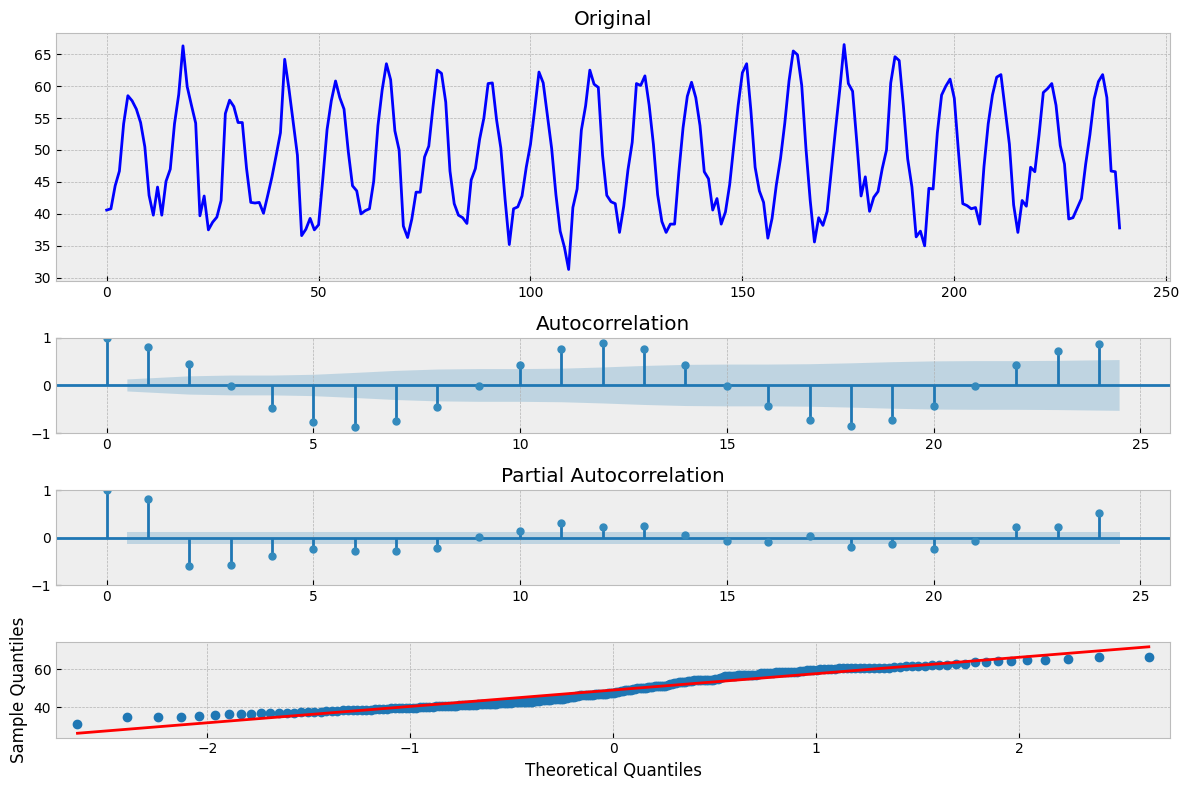

In [7]:
tsplot(series)

Временной ряд стационарный, но есть сезонность

In [8]:
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series

array([ 0.08495672, -0.02481517,  0.01564278,  0.00640344,  0.        ,
        0.00341297,  0.13893272,  0.06020735,  0.04852704,  0.07070757,
       -0.07752064,  0.07267119, -0.16438386, -0.02802731, -0.13258157,
       -0.11009986,  0.02914596, -0.01545095, -0.15465357, -0.09815228,
       -0.04852704, -0.14040791,  0.05154515, -0.02603697,  0.10855541,
        0.03553673,  0.08257115,  0.08423635, -0.12408652, -0.09237332,
        0.12246688,  0.09313135,  0.00183993,  0.04362062, -0.1328481 ,
       -0.10349708, -0.06167182, -0.0670354 , -0.11342193, -0.00657177,
        0.07816477,  0.09064172, -0.05441342, -0.02377022,  0.036105  ,
        0.01212136,  0.19319123,  0.1480531 ,  0.01765494,  0.07696104,
        0.06323219, -0.00883008,  0.01121507,  0.02903705,  0.04345012,
        0.04698851, -0.06217724,  0.00400802, -0.15302519, -0.18323941,
       -0.02020271,  0.06915747,  0.06177736,  0.08089515, -0.06132189,
       -0.0447579 , -0.01587335,  0.01626052,  0.08149303, -0.06

Results of Dickey-Fuller Test:
Test Statistic                -6.411725e+00
p-value                        1.883599e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


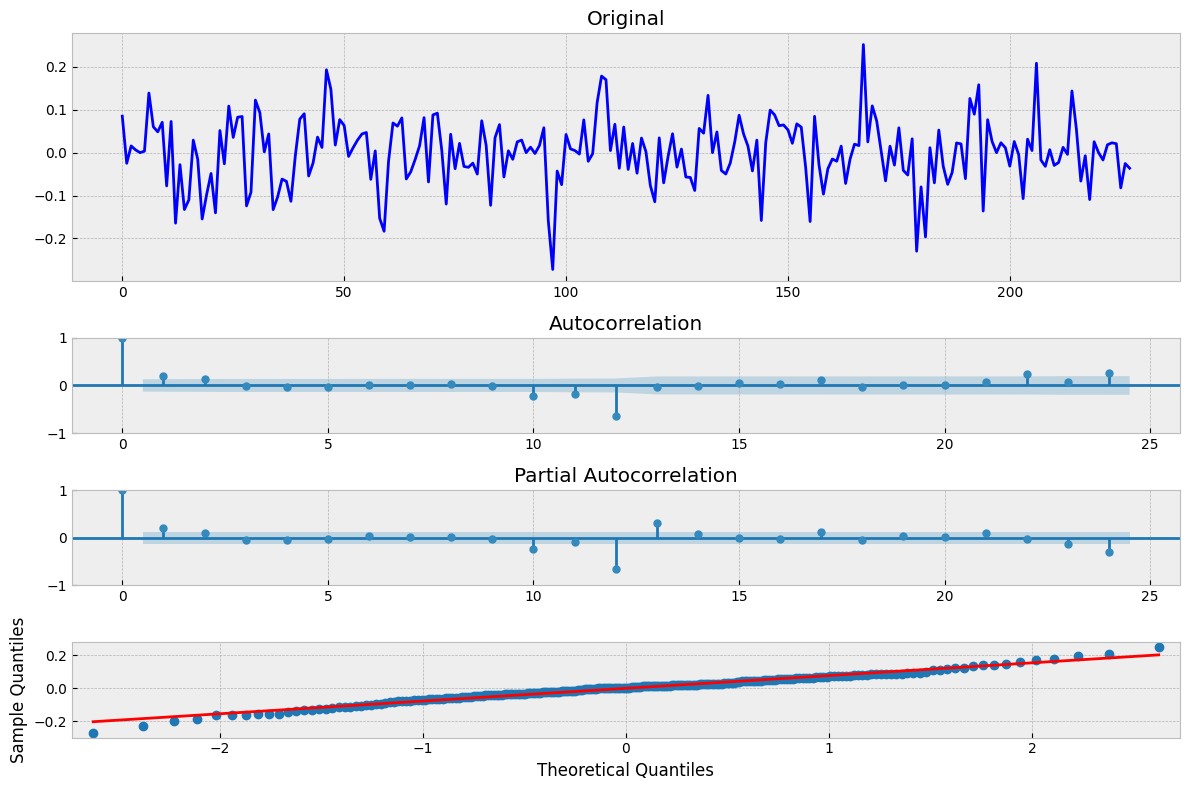

In [9]:
tsplot(series)

Сезонность удалось убрать. Построим модель ARIMA на полученных данных. Сначала подберем отптимальные параметры p, q, d.

In [10]:
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -545.74558 | order: (3, 0, 3)


In [11]:
mymodel = smt.ARIMA(series, order =(3, 0, 3))
modelfit = mymodel.fit()
print(modelfit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  228
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 280.873
Date:                Fri, 16 Jun 2023   AIC                           -545.746
Time:                        19:06:54   BIC                           -518.311
Sample:                             0   HQIC                          -534.676
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.006     -0.044      0.965      -0.013       0.012
ar.L1          0.1847      0.074      2.505      0.012       0.040       0.329
ar.L2          0.0809      0.089      0.910      0.3

В принципе, можно попробовать улучшить AIC, убрав коэффициенты с $p$ > 0.05. "Делать это мы, конечно, не будем" (с)

Проверим остатки, чтобы убедиться, что нет таких закономерностей, как постоянное среднее значение и дисперсия.

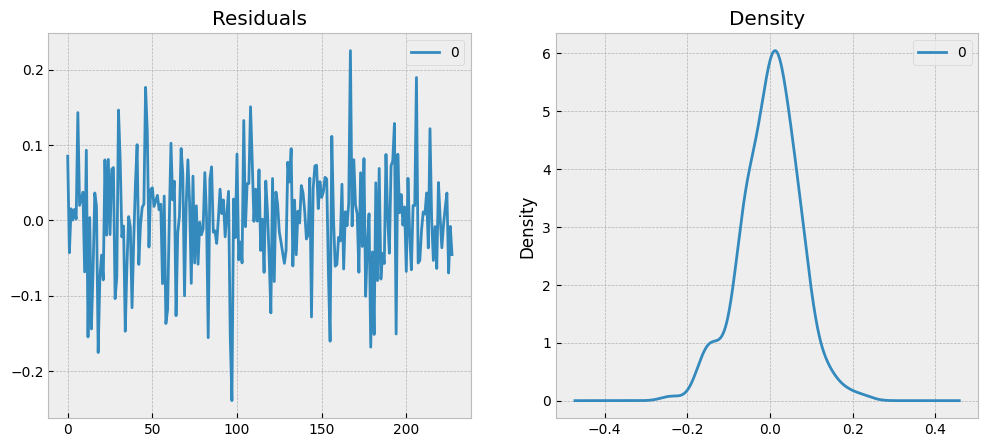

In [12]:
myresiduals = pd.DataFrame(modelfit.resid)
with plt.style.context('bmh'):
  fig, ax = plt.subplots(1,2, figsize=(12, 5))
  myresiduals.plot(title = "Residuals", ax = ax[0])
  myresiduals.plot(kind = 'kde', title = 'Density', ax = ax[1])
  plt.show()

На глаз вроде все более-менее: среднее около нуля, дисперсия также относительно равномерна

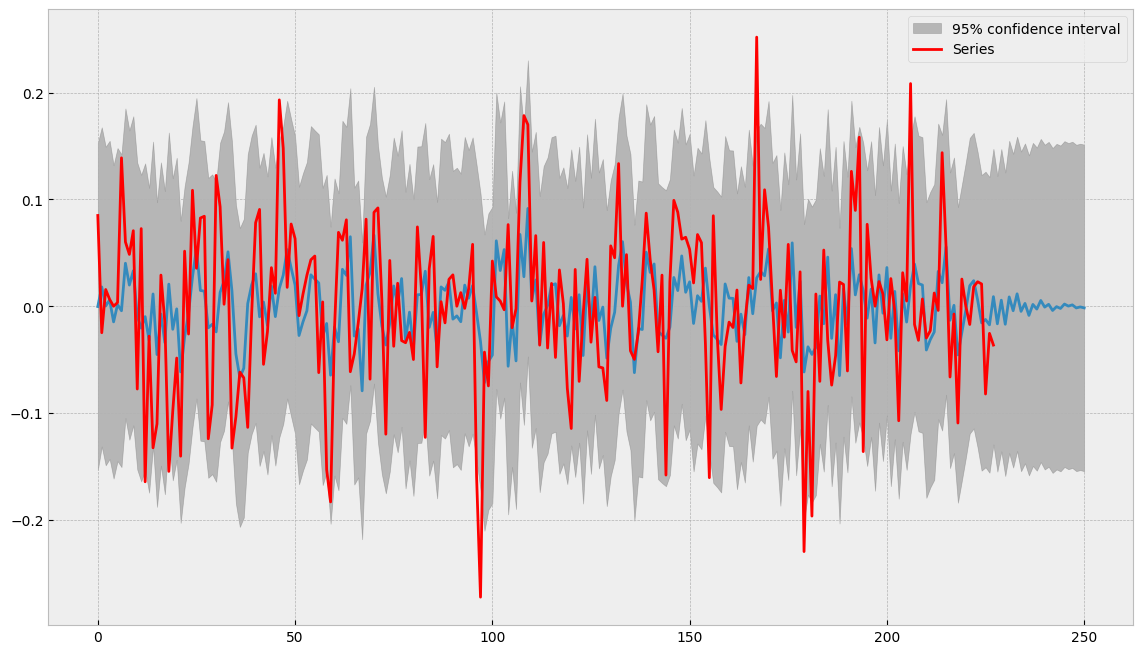

In [18]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(modelfit, 0, 250, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Получилась какая-то ерунда. Модель отработала плохо. Возможно из-за того, что, скопировав материалы лекции, я забыл, что ARIMA работает с нестационарными рядами и не надо было делать преобразование Бокса-Кокса.

In [14]:
temper = pd.read_csv("https://raw.githubusercontent.com/MelnikDM/Netology/main/Time_Series/data/mean-monthly-air-temperature-deg.csv")["Deg"]

In [15]:
best_aic = np.inf
best_order = None
best_md_2 = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(temper, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl_2 = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 1136.24457 | order: (3, 0, 2)


In [22]:
mymodel_2 = smt.ARIMA(temper, order =(3, 0, 2))
modelfit_2 = mymodel_2.fit()
print(modelfit_2.summary())

                               SARIMAX Results                                
Dep. Variable:                    Deg   No. Observations:                  240
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -561.122
Date:                Fri, 16 Jun 2023   AIC                           1136.245
Time:                        19:22:18   BIC                           1160.609
Sample:                             0   HQIC                          1146.062
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.0282      0.212    230.971      0.000      48.612      49.444
ar.L1          2.0209      0.068     29.619      0.000       1.887       2.155
ar.L2         -1.4990      0.118    -12.754      0.0

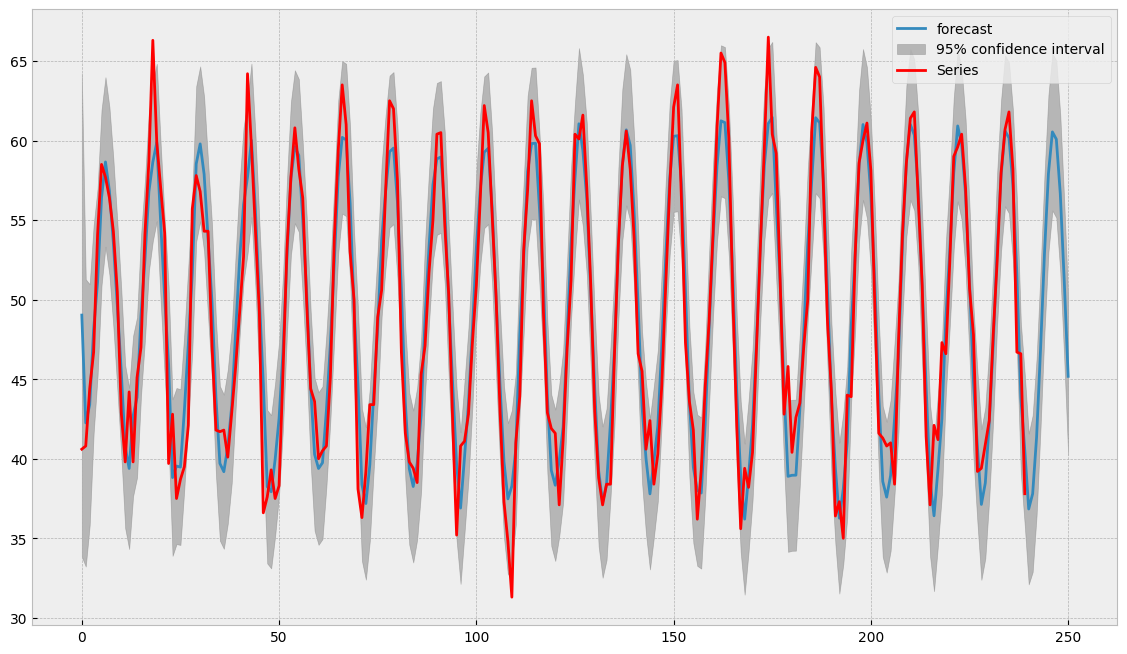

In [23]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(modelfit_2, 0, 250, ax=ax)
    plt.plot(temper, color='red', label='Series')
    plt.legend()
    plt.show()

Теперь все стало значительно лучше.